In [60]:
#####################
# Library Loading
#####################
suppressPackageStartupMessages({
    library(tidyverse)
    library(ggplot2)
    library(tools)
    library(ggsci)
    library(scales)
    library(ComplexHeatmap)
    library(cowplot)
    library(gplots)
    library(RColorBrewer)
    library(gridExtra)
    library(ggrepel)
})

In [61]:
######################
# SETTING
######################
args = commandArgs(trailingOnly=TRUE)
options(scipen=10000000)
PLOTLY_Pallett = c('#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf')
JCO_PALLETT = pal_jco("default")(10)
FEATURE_PALLETT = PLOTLY_Pallett
SAMPLE_PALLETT = c("#FF7F00", "#6A3D9A", "#2CA02C")

OFFLINE_MODE=FALSE

if(OFFLINE_MODE==FALSE){
    options(repr.plot.width=10, repr.plot.height=5, repr.plot.res=200)
}

In [62]:
######################
# INPUT/OUTPUT
#####################
if(OFFLINE_MODE==FALSE){
    target_file_Path = "./template/16S_Saboo_Cirrhosis_Male_VS_16S_Saboo_Cirrhosis_Female.PWY.univariate.metastats.feature_volcano.plot.txt"
    feature_column_name = "Lineage"
    pvalue_column_name = "pvalue"
    statistics_method_title = "metastats"
    logFC_column_name = "LOG2FC"
    direction_column_name = "Direction"
}else{
    abundance_file_Path = args[1]
    metadata_file_Path = args[2]
    taxonomy_file_Path = args[3]
    differential_abundance_file_Path = args[4]
    selected_lineage = args[5]
    the_Method = args[6]
    plot_output = args[7]
}

In [63]:
#####################
# READ I/O
#####################
target_DF = read_tsv(target_file_Path)
head(target_DF, n=5L)

Parsed with column specification:
cols(
  Lineage = col_character(),
  LOG2FC = col_double(),
  abs_LOG2FC = col_double(),
  Direction = col_character(),
  pvalue = col_double(),
  Total = col_double()
)


Lineage,LOG2FC,abs_LOG2FC,Direction,pvalue,Total
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1CMET2_PWY_N10_formyl_tetrahydrofolate_biosynthesis,-1.65,1.65,Cirrhosis_M,0.89710301,2984105
3_HYDROXYPHENYLACETATE_DEGRADATION_PWY_4_hydroxyphenylacetate_degradation,-0.95,0.95,common,0.18281701,70745
AEROBACTINSYN_PWY_aerobactin_biosynthesis,-2.72,2.72,Cirrhosis_M,0.27972001,20590
ALL_CHORISMATE_PWY_superpathway_of_chorismate_metabolism,-1.58,1.58,Cirrhosis_M,0.80819201,269010
ANAEROFRUCAT_PWY_homolactic_fermentation,-1.75,1.75,Cirrhosis_M,0.02197801,2985257


In [79]:
#####################
# process data
#####################
processed_target_DF = target_DF %>%
    rename(FEATURE_ID=!!feature_column_name, PVALUE=!!pvalue_column_name, LOGFC=!!logFC_column_name, FEATURE_DIRECTION = !!direction_column_name) %>%
    mutate(NEG_LOG10_PVALUE = -log10(PVALUE))
head(processed_target_DF)
#
processed_target_DF_INFO = processed_target_DF %>% summarise(MIN_LOGFC = min(LOGFC), MAX_LOGFC = max(LOGFC), MAX_NEG_LOG10_PVALUE = max(NEG_LOG10_PVALUE)) %>%
    mutate(LOGFC_EXTREMUM = ifelse(abs(MIN_LOGFC) > abs(MAX_LOGFC), abs(MIN_LOGFC), abs(MAX_LOGFC)) )
processed_target_DF_INFO
#
labeled_feature_DF = processed_target_DF %>%
    filter(FEATURE_DIRECTION != "common" & NEG_LOG10_PVALUE > 1.30 & abs(LOGFC) >= 1) %>%
    #arrange(desc(abs(LOGFC))) %>%
    group_by(FEATURE_DIRECTION) %>%
    top_n(n = 20, wt=abs(LOGFC)) %>%
    mutate(label = str_remove(FEATURE_ID, regex("PWY_\\d{4}_")))
head(labeled_feature_DF)

FEATURE_ID,LOGFC,abs_LOG2FC,FEATURE_DIRECTION,PVALUE,Total,NEG_LOG10_PVALUE
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1CMET2_PWY_N10_formyl_tetrahydrofolate_biosynthesis,-1.65,1.65,Cirrhosis_M,0.89710301,2984105,0.04715769
3_HYDROXYPHENYLACETATE_DEGRADATION_PWY_4_hydroxyphenylacetate_degradation,-0.95,0.95,common,0.18281701,70745,0.73798340
AEROBACTINSYN_PWY_aerobactin_biosynthesis,-2.72,2.72,Cirrhosis_M,0.27972001,20590,0.55327646
ALL_CHORISMATE_PWY_superpathway_of_chorismate_metabolism,-1.58,1.58,Cirrhosis_M,0.80819201,269010,0.09248545
ANAEROFRUCAT_PWY_homolactic_fermentation,-1.75,1.75,Cirrhosis_M,0.02197801,2985257,1.65801163
ANAGLYCOLYSIS_PWY_glycolysis_III_from_glucose,-1.69,1.69,Cirrhosis_M,0.26273701,4143761,0.58047875


MIN_LOGFC,MAX_LOGFC,MAX_NEG_LOG10_PVALUE,LOGFC_EXTREMUM
<dbl>,<dbl>,<dbl>,<dbl>
-11.88,8.92,8,11.88


FEATURE_ID,LOGFC,abs_LOG2FC,FEATURE_DIRECTION,PVALUE,Total,NEG_LOG10_PVALUE,label
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
CHLOROPHYLL_SYN_chlorophyllide_a_biosynthesis_I_aerobic_light_dependent,-9.62,9.62,Cirrhosis_M,0.03196801,785,1.495284,CHLOROPHYLL_SYN_chlorophyllide_a_biosynthesis_I_aerobic_light_dependent
P101_PWY_ectoine_biosynthesis,-11.17,11.17,Cirrhosis_M,0.00099901,2298,3.000430,P101_PWY_ectoine_biosynthesis
PWY_1361_benzoyl_CoA_degradation_I_aerobic,-6.71,6.71,Cirrhosis_M,0.00000001,104,8.000000,benzoyl_CoA_degradation_I_aerobic
PWY_1422_vitamin_E_biosynthesis_tocopherols,-7.42,7.42,Cirrhosis_M,0.00000001,170,8.000000,vitamin_E_biosynthesis_tocopherols
PWY_3661_glycine_betaine_degradation_I,-11.20,11.20,Cirrhosis_M,0.03196801,2348,1.495284,glycine_betaine_degradation_I
PWY_3801_sucrose_degradation_II_sucrose_synthase,-7.67,7.67,Cirrhosis_M,0.00000001,202,8.000000,sucrose_degradation_II_sucrose_synthase


In [65]:
####################
#PLOT CONSTANT
####################
max_x_axis = processed_target_DF_INFO$LOGFC_EXTREMUM + 5
min_x_axis = -processed_target_DF_INFO$LOGFC_EXTREMUM - 5
#
max_y_axis = processed_target_DF_INFO$MAX_NEG_LOG10_PVALUE + 5
min_y_axis = 0


In [66]:
####################
#PLOT ORDER/COLOR
####################
direction_List = sort(unique(processed_target_DF$FEATURE_DIRECTION))
direction_List_Length = length(direction_List)
#
Sample_Size = length(direction_List)
Sample_Order_List = direction_List
Sample_Label_Dict = Sample_Order_List
names(Sample_Label_Dict) = Sample_Order_List
Sample_Order_Factor = factor(Sample_Order_List, levels=Sample_Order_List)
Sample_Color_List = SAMPLE_PALLETT[1:Sample_Size]
Sample_Color_Dict = Sample_Color_List
names(Sample_Color_Dict) = Sample_Order_List

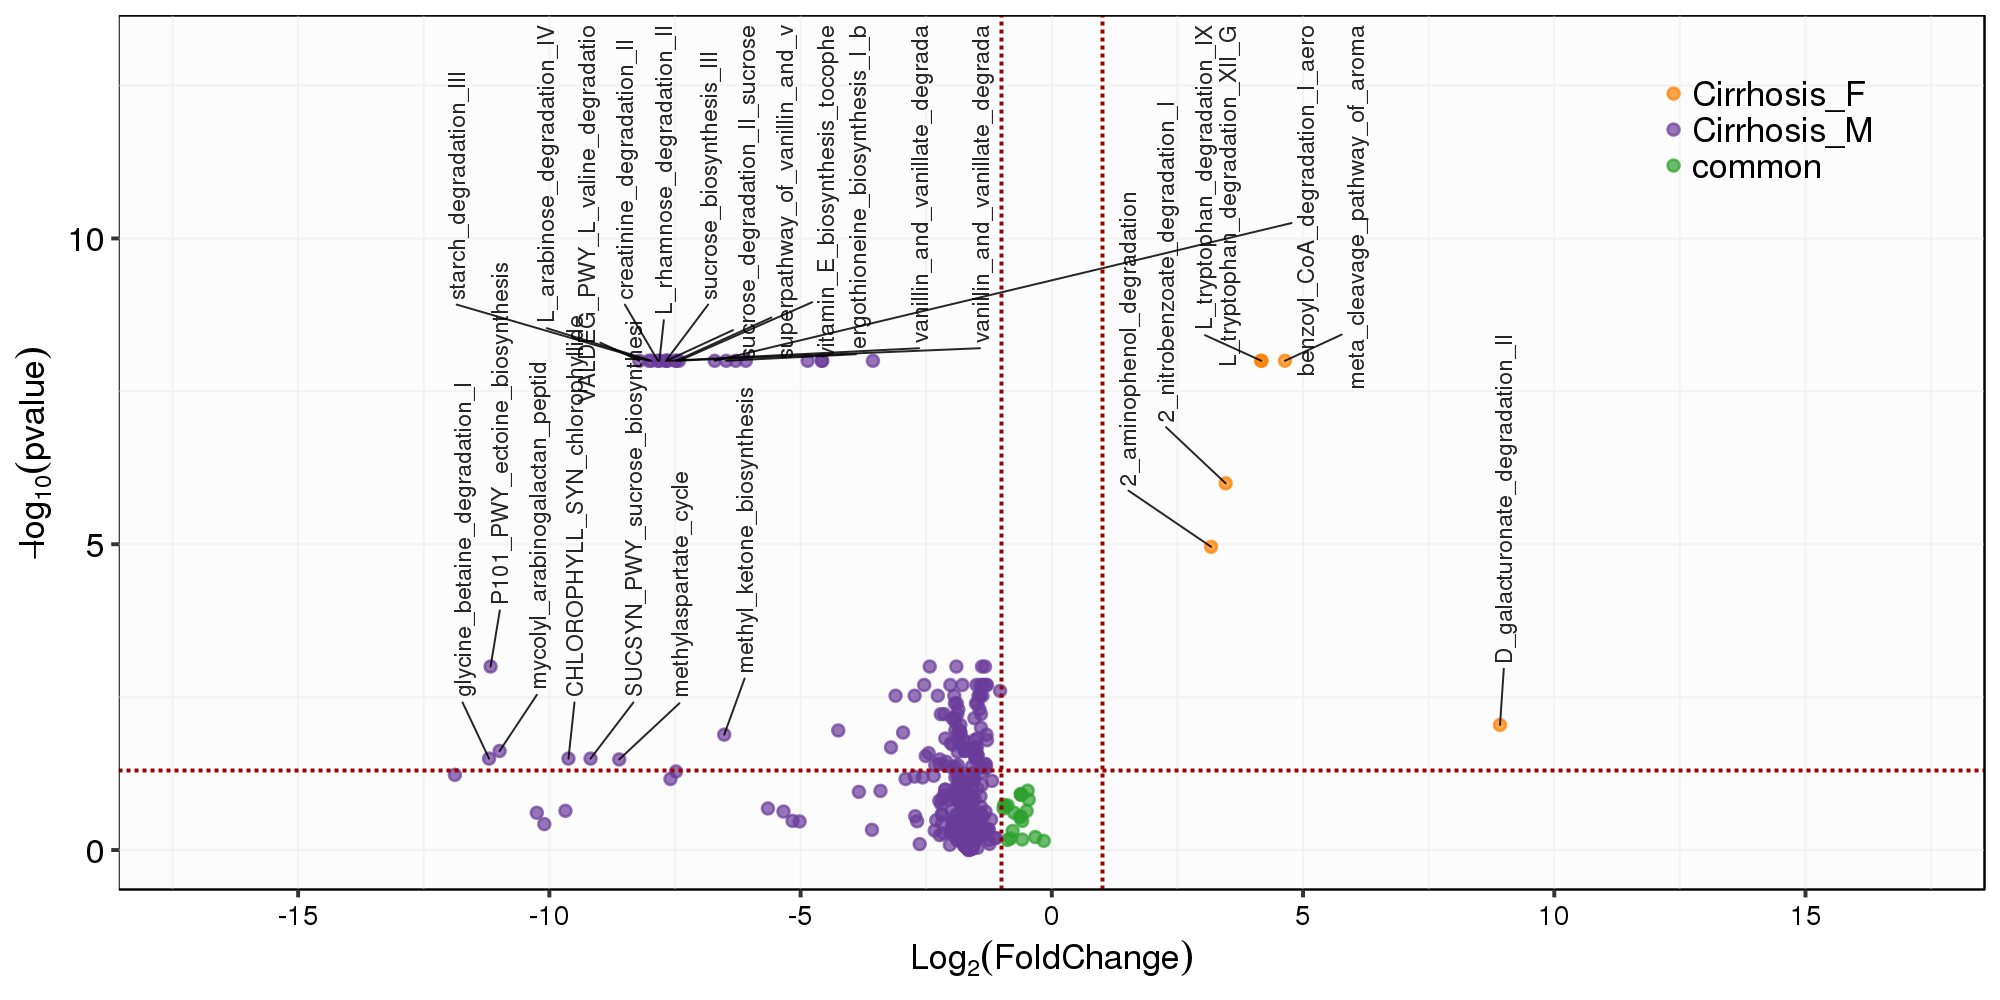

In [82]:
volcano_ggplot_Object = ggplot(processed_target_DF, aes(x = LOGFC, y = NEG_LOG10_PVALUE, labels=FEATURE_ID, color=FEATURE_DIRECTION)) +
    geom_point(size = 1.5, alpha = 0.7, na.rm = T, aes(col=FEATURE_DIRECTION)) +
    scale_colour_manual(breaks = Sample_Order_List, labels=Sample_Label_Dict, limits=Sample_Order_List, values=Sample_Color_Dict, guide = guide_legend(reverse = FALSE),name = NULL) +
    labs(title = NULL, subtitle = NULL, caption = NULL, tag = NULL, x=expression(Log[2]("FoldChange")), y=expression(-log[10]("pValue"))) +
    theme_grey() +
    theme(
        text=element_text(family="sans"),
        plot.title = element_text(size=14, color = "black", face = "plain", hjust = 0),
        plot.subtitle = element_text(size=12, color = "black", face = "plain", hjust = 0 ),
        plot.caption = element_text(size=10, color = "black", face = "plain"),
        #X-AXIS
        axis.title.x = element_text(size=12, color = "black", face = "plain"),
        axis.text.x = element_text(size=10, color = "black", face = "plain"),
        #Y-AXIS
        axis.title.y = element_text(size=12, color = "black", face = "plain"),
        axis.text.y = element_text(size=12, color = "black", face = "plain"),
        #Panel
        panel.grid.major = element_line(color = "grey95", size = 0.25), 
        panel.grid.minor = element_line(color = "grey95", size = 0.25),
        panel.background = element_rect(color = "black", size = 0.25, fill = "grey99"),
        panel.border = element_rect(color = "black", size = 0.25, fill = NA),
        #LEGEND
        
        legend.title = element_blank(),
        legend.text = element_text(size=12, color = "black", face = "plain"),
        legend.key = element_rect(colour = NA, fill = NA),
        legend.key.size = unit(0.9,"line"),
        legend.background = element_blank(),
        #legend.position = "bottom",
        legend.position = c(.95, .95),
        legend.justification = c("right", "top"),
        legend.box.just = "right",
        legend.margin = margin(6, 6, 6, 6)
         ) + 
    xlab(expression(Log[2]("FoldChange"))) + 
    ylab(expression(-log[10]("pvalue"))) +
    geom_hline(yintercept = 1.30102999566, colour="#990000", linetype="dashed") + 
    geom_vline(xintercept = 1, colour="#990000", linetype="dashed") + 
    geom_vline(xintercept = -1, colour="#990000", linetype="dashed") +
    scale_x_continuous(limits=c(min_x_axis, max_x_axis), breaks = scales::pretty_breaks(n = 10)) +
    scale_y_continuous(limits=c(min_y_axis, max_y_axis), breaks = scales::pretty_breaks(n = 5)) +
    geom_text_repel(data=labeled_feature_DF, 
                    aes(label=substr(label, start = 1, stop = 30)), 
                    size=2.8, 
                    color='black',
                    #box.padding = unit(0.35, "lines"),
                    #point.padding = unit(0.3, "lines"),
                    alpha = 0.85, 
                    na.rm = TRUE, # Color of the line segments.
                    segment.color = 'black',
                    # Width of the line segments.
                    segment.size = 0.25,
                    nudge_y = 1,
                    direction = "x",
                    angle = 90,
                    vjust = 0)
volcano_ggplot_Object
Cirrhosis_Male_VS_Cirrhosis_Female = plot_grid(volcano_ggplot_Object, nrow=1)

In [83]:
ggsave(file="./template/Cirrhosis_Male_VS_Cirrhosis_Female.pdf", device=cairo_pdf, plot=Cirrhosis_Male_VS_Cirrhosis_Female, width = 10, height = 5, units = "in", dpi=1200)

In [84]:

save(Cirrhosis_Male_VS_Cirrhosis_Female, file="./template/Cirrhosis_Male_VS_Cirrhosis_Female.Robj")